# Astrophysical inference for gravitational-wave transients

In this colab notebook we will review some of tools `Bilby` has for doing Bayesian inference on gravitational-wave transients.

The BILBY paper is: https://ui.adsabs.harvard.edu/abs/2019ApJS..241...27A/abstract

***From the Abstract:*** Bayesian parameter estimation is fast becoming the language of gravitational-wave astronomy. It is the method by which gravitational-wave data is used to infer the sources’ astrophysical properties. It allows users to perform accurate and reliable gravitational-wave parameter estimation on both real, freely available data from LIGO/Virgo and simulated data. We provide a suite of examples for the analysis of compact binary mergersand other types of signal models, including supernovae and the remnants of binary neutron star mergers. These examples illustrate how to change the signal model, implement new likelihood functions, and add new detectors.

More recently, PYCBC INFERENCE, a modern, PYTHON-based tool kit designed
for compact binary coalescence parameter estimation, was released. This package provides access to several different samplers and builds on the PYCBC package, an open-source tool kit for gravitational-wave astronomy.

The ***CHALLENGE*** is to Determine 15 parameters for a Black Hole Binary (typically calculated 1 or 2 at a time): 

***Intrinsic (8):*** 2 black hole masses, spin of black holes (6 parameters)

***Extrinsic (7):*** luminosity distance,R.A, Decl., inclination angle between observer and angular momentum, polarization angle, phase at coalescence, coalescence time.

There are more [examples](https://git.ligo.org/lscsoft/bilby/tree/master/examples/gw_examples) in the `Bilby` git repository.

# Bayesian Analysis and Terms

P(Θ|D) = P(D|Θ) P(Θ) / P(D)

P(D|Θ) is the **likelihood**. This is the probability of seeing the data D generated by a model with parameter **Θ**.

P(Θ) is the **prior**. Our belief of the value of Θ before considering the evidence D.

P(D) is the **evidence**. This is the probability of the data determined by integrating across all possible values of **Θ**, weighted by how strongly we believe in those particular values of **Θ**.

P(Θ|D) is the **posterior**. This is the (refined) strength of our belief of **Θ** once the evidence **D** has been taken into account.

The goal of Bayesian inference is to provide a mathematically sound procedure for incorporating prior beliefs, with any evidence at hand, in order to produce an updated posterior belief.

Notes on these pieces are included below.

### Install packages

Since this notebook was written for [colab](colab.research.google.com) we have to install the relevant packages using `pip install`.

We install
- `Bilby`: this is the library used for Bayesian inference, it also has tools for gravitational-wave transients.
- `LALSuite`: the LIGO Algorithms Library, `Bilby` (generally) uses `lalsimulation` to generate waveforms.
- `gwpy`: a package for interfacing with gravitational-wave data, it is the most convenient way to access open or proprietary data.

### HEED THE WARNING and RESTART THE RUNTIME

In [ ]:
!pip install bilby lalsuite gwpy

## Imports

Most of the imports are here.
Explanations of elements will be given where they're first used.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import bilby

from bilby import run_sampler

from bilby.core.prior import Constraint, Uniform

from bilby.gw.conversion import (
    convert_to_lal_binary_black_hole_parameters,
    generate_all_bbh_parameters
)
from bilby.gw.detector.networks import InterferometerList
from bilby.gw.detector.psd import PowerSpectralDensity
from bilby.gw.likelihood import GravitationalWaveTransient
from bilby.gw.prior import BBHPriorDict
from bilby.gw.result import CBCResult
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.utils import get_event_time
from bilby.gw.waveform_generator import WaveformGenerator

from gwpy.timeseries import TimeSeries

## Accessing data

In this example we access the data to analyse the end of the inspiral for GW170814. The original notebook omitted the "GW" preface.

To make the analysis run in a reasonable time we're going to just look at the final ~3s of the inspiral.

We ask for 128s of data after the signal in order to estimate the power spectral density.

The methods below are adapted from [`bilby_pipe.data_generation`](https://git.ligo.org/lscsoft/bilby_pipe/blob/master/bilby_pipe/data_generation.py).

Using 2 LIGO and 1 Virgo detectors (interferometers)

In [ ]:
interferometers = InterferometerList(["H1", "L1", "V1"])
trigger_time = get_event_time("GW170814")

### First we need to specify information on how much data to get and how it should be processed.

We fetch a 4s stretch of data and put the trigger time `3`s through the
segment.

We also specify the "roll_off", this tells use how quickly the [tukey window]() applied to the data before performing the fast fourier transform of the data should fall off.
This is in units of seconds.
A fall off of `0` is a rectangular window and leads to issues due to the "lines" (sharp features in the power spectrum).
We should always be careful to not apply the window to part of the signal being analysed.

This is where using wavelets would be advantageous.

In [ ]:
start_time = trigger_time - 3
duration = 4
end_time = start_time + duration
roll_off = 0.2

for interferometer in interferometers:
    print(
        "Getting analysis segment data for {}".format(interferometer.name)
    )
    analysis_data = TimeSeries.fetch_open_data(
        interferometer.name, start_time, end_time
    )
    interferometer.strain_data.roll_off = roll_off
    interferometer.strain_data.set_from_gwpy_timeseries(analysis_data)


Getting analysis segment data for H1
Getting analysis segment data for L1
Getting analysis segment data for V1


### Now we need to get the data to compute the power spectral density (PSD).
This uses FFT (Fast Fourier Transforms) to transform a time series to the frequency domain.

We average over multiple segments.
We take the median average.

In [ ]:
actual_psd_start_time = start_time + duration
psd_duration = 128
actual_psd_end_time = actual_psd_start_time + psd_duration
psd_tukey_alpha = 2 * roll_off / duration
overlap = duration / 2

for interferometer in interferometers:
    print("Getting psd segment data for {}".format(interferometer.name))
    psd_data = TimeSeries.fetch_open_data(
        interferometer.name, actual_psd_start_time, actual_psd_end_time
    )
    psd = psd_data.psd(
        fftlength=duration, overlap=overlap, window=("tukey", psd_tukey_alpha),
        method="median"
    )
    interferometer.power_spectral_density = PowerSpectralDensity(
        frequency_array=psd.frequencies.value, psd_array=psd.value
    )


Getting psd segment data for H1
Getting psd segment data for L1
Getting psd segment data for V1


### Finally let's plot the data
Strain is the power of the signal (deformation of the interferometer) by frequency. Think of frequency as a pitch in sound.

22:52 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:52 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


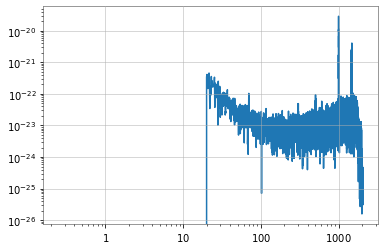

22:52 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:52 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


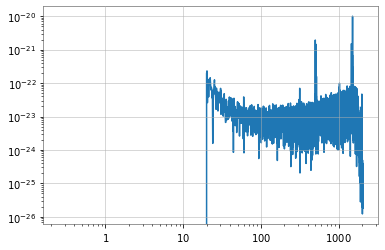

22:52 bilby INFO    : Generating frequency domain strain from given time domain strain.
22:52 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


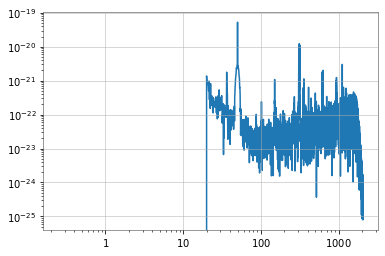

In [ ]:
for interferometer in interferometers:
  plt.loglog(interferometer.frequency_array, abs(interferometer.frequency_domain_strain))
  plt.show()
  plt.close()

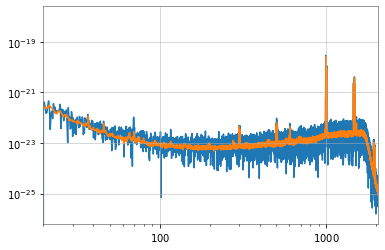

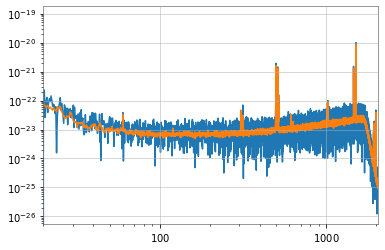

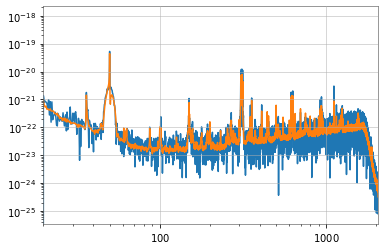

In [ ]:
for interferometer in interferometers:
    plt.loglog(interferometer.frequency_array, abs(interferometer.frequency_domain_strain))
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array))
    plt.xlim(interferometer.minimum_frequency, interferometer.maximum_frequency)
    plt.show()
    plt.close()

## Setting up our model

### Now that we have data we need a model to construct out likelihood

In this case our model will be a gravitational-wave template for a binary black hole merger.

This is accessed using a `waveform_generator`.

This is given:
- the duration and sampling frequency of the data that we want to compare the model to.
- a `frequency_domain_source_model`, this is a python function which returns the waveform template given the parameters. For details of how to define such a model see [here](https://git.ligo.org/lscsoft/bilby/blob/master/bilby/gw/source.py).
- a `parameter_conversion` function, this enables the user to sample in parameters that aren't directly used by the source model, e.g., sampling in chirp mass and mass ratio instead of component masses.
- `waveform_arguments`, this is a dictionary of arguments which are passed to the source model which should not be sampled, e.g., the waveform approximant/reference frequency.

This source model calls down to `lalsimulation` and should be able to use any waveform model implemented in that pakage.

Other options:
- a `time_domain_source_model` can be passed as an alternative to the `frequency_domain_source_model`, this will then be FFT'd if used in the likelihood below.

In [ ]:
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=20
)

waveform_generator = WaveformGenerator(
    duration=interferometers.duration,
    sampling_frequency=interferometers.sampling_frequency,
    frequency_domain_source_model=lal_binary_black_hole,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments
)

22:52 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


## Prior choice

`Bilby` has a built in `BBHPriorDict` class which has all the necessary parameters for sampling a binary black hole system.

We'll use that as a base but then make a few adjustments.

- we specify to use aligned spins rather than the full six-dimensional spins.
- we need to add a prior for time as that is difficult to define a default prior for.
- we remove the priors on the component masses and repace them with priors on the chirp mass and mass ratio as those are parameters which are easier to sample in.

In [ ]:
priors = BBHPriorDict(aligned_spin=True)
priors["chirp_mass"] = Uniform(
    minimum=24, maximum=30,
    latex_label="$\\mathcal{M}$", unit="$M_{\\odot}$", boundary="reflective"
)
priors["mass_ratio"] = Uniform(
    minimum=0.4, maximum=1, latex_label="$q$", boundary="reflective"
)
del priors["mass_1"], priors["mass_2"]

priors["geocent_time"] = Uniform(
    minimum=trigger_time - 0.1, maximum=trigger_time + 0.1,
    latex_label="$t_c$", unit="$s$", boundary="reflective"
)

22:52 bilby INFO    : Using aligned spin prior
22:52 bilby INFO    : No prior given, using default BBH priors in /usr/local/lib/python3.7/dist-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [ ]:
for key in priors:
    print(f"{key}: {priors[key]}")

mass_ratio: Uniform(minimum=0.4, maximum=1, name=None, latex_label='$q$', unit=None, boundary='reflective')
chirp_mass: Uniform(minimum=24, maximum=30, name=None, latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary='reflective')
luminosity_distance: UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None)
dec: Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
ra: Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic')
theta_jn: Sine(minimum=0, maximum=3.141592653589793, name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, boundary=None)
psi: Uniform(minimum=0, maximum=3.141592653589793, name='psi', latex_label='$\\psi$'

Let's take a look at what priors we have.

These are mostly uniform with just a few exceptions.

- Since we're only considering aligned spins we are using the `bilby.gw.prior.AlignedSpin` class.
This takes a prior on spin magnitude $a$ and _cosine_ spin tilt $z$ and calculates the implied prior on the aligned component of the spin.
- For luminosity distance we use the `bilby.gw.prior.UniformSourceFrame` prior. This ensures that our prior belief on distance is that events happen uniformly throughout the universe. The `cosmology` argument can either be an astropy `Cosmology` object or the name of a known cosmology, e.g., `WMAP9`.
- `dec` and `theta_jn` have `Cosine` and `Sine` priors respectively, these are saying that the prior distribution is proportional to the appropriate trignometric function.
These are chose so that the prior is uniform over the sphere.

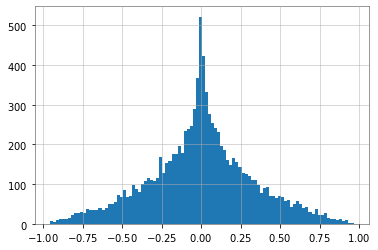

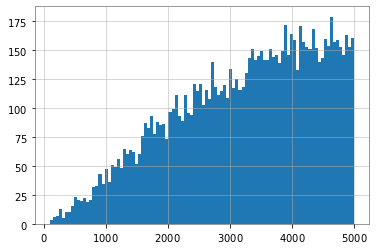

In [ ]:
prior_samples = priors.sample(10000)

plt.hist(prior_samples["chi_1"], bins=100)
plt.show()
plt.close()

plt.hist(prior_samples["luminosity_distance"], bins=100)
plt.show()
plt.close()

## Let's make a likelihood!

The standard likelihood used in gravitational-wave transient inference is the [Whittle Likelihood](https://en.wikipedia.org/wiki/Whittle_likelihood)
$$\mathcal{L}(d | \theta) = \prod_{i} \prod_{j} \frac{1}{2 \pi S_{i,j} } \exp\left( -\frac{|\tilde{d}_{i,j} - \tilde{h}_{i,j}(\theta)|^2}{2S_{i,j} } \right).$$
The product here is over detectors $i$ and frequency bins $j$.
$\tilde{d}$ is the frequency-domain strain data, $\tilde{h}$ is the template waveform, and $S$ is the noise power spectral density.

In practice we are only interested in the (logarithm of) the terms which depend on the binary parameters.
In this case we define the "log likelihood ratio" as follows
$$\ln \mathcal{L} = \sum_{j} \sum_{j} - \frac{1}{2} |\tilde{h}_{i,j}|^2 + \mathbb{R}\left( \tilde{d}_{i,j}^{*} \tilde{h}_{i,j} \right).$$

_Note_: There are exceptions, e.g., when the power spectral density is modeled.

There are some parameters which alter the template (and by extension the likelihood) in simple ways. The `GravitationalWaveTransient` likelihood in `Bilby` has implementation of marginalisation over the distance, time, and phase.

The likelihood takes the following arguments
- `interferometers`: this is the data for our likelihood
- `waveform_generator`: this is our model for the signal
- `priors`: if we use any of the marginalisations we need to provide the prior. The priors for the marginalised parameters are modified in place to fiducial values
- `distance_marginalization`: whether to marginalize the likelihood over distance. I generally recommend using this as it removes the distance/inclination degeneracy and the posterior can be generated in post-processing. I've disabled it in this example as it takes a few minutes to set up the required lookup table.
- `phase_marginalization`: whether to marginalize the likelihood over phase. Marginalising over phase analytically removes the degeneracy with polarisation. Note that this is only valid when there are no higher-order modes in the waveform.
- `time_marginalization`: whether to marginalize the likelihood over time. This uses a FFT to marginalise over time.
- `jitter_time`: when using the `time_marginalization` option the likelihood is evaluated on a fixed grid of times. To avoid coarse-graining issues on this grid we have the ablililty to sample in the position of the grid.

_Note_: If you're using `bilby<0.5.6` there is a message `Time jittering requested with non-time-marginalised likelihood, ignoring.`. Ignore this.

In [ ]:
likelihood = GravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=waveform_generator,
    priors=priors, time_marginalization=False, distance_marginalization=False,
    phase_marginalization=True
)

## It's samplin' time. This uses Markov Chain Monte Carlo (MCMC)

To make this run in just a few minutes the sampler setting are woefully inadequate to have faith in the results.

The do a better run increase `nlive` and `walks`, for the review we are using nlive $= O(1000)$ and walks $= O(100)$.
For details on the specific sampler and others, see the documentation either in [`Bilby`](https://docs.ligo.org/lscsoft/bilby/samplers.html) or the individual samplers, e.g., [`dynesty`](https://dynesty.readthedocs.io/en/latest/api.html).

We pass a `conversion_function` which is applied after the sampling has finished. In this case we tell it to `generate_all_bbh_parameters`, this generates all the parameters that `Bilby` knows how to produce for binary black hole systems. This includes constructing the posterior for the marginalised parameters.

In [ ]:
result = run_sampler(
    likelihood=likelihood, priors=priors, save=False,
    nlive=50, walks=25,
    conversion_function=generate_all_bbh_parameters,
    result_class=CBCResult)

22:53 bilby INFO    : Running for label 'label', output will be saved to 'outdir'
22:53 bilby INFO    : Using lal version 7.1.7
22:53 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
22:53 bilby INFO    : Using lalsimulation version 3.1.2
22:53 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
22:53 bilby INFO    : Search parameters:
22:53 bilby INFO    :   mass_ratio = Uniform(minimum=0.4, maximum=1, name=None, latex_label='$q$', unit=None, boundary='reflective')
22:53 bilby INFO    :   chirp_mass = Uniform(minimum=24, maximum=30, name=None, latex_label='$\\mathcal{M}$', unit='$M_{\\odot}$', boundary='reflective')
22:53 bilby INFO    :   luminosity_distance = UniformSourceFrame(minimum=100.0, maxi

0it [00:00, ?it/s]

22:53 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 50, 'first_update': None, 'walks': 25, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 30, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f41d6cff1d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
22:53 bilby INFO    : Checkpoint every check_point_delta_t = 600s
22:53 bilby INFO    : Using dynesty version 1.0.1
22:53 bilby INFO    : Using the bilby-

  0%|          | 0/1386 [00:00<?, ?it/s]

23:14 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/1386 [00:00<?, ?it/s]

23:14 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/1386 [00:00<?, ?it/s]

23:14 bilby INFO    : Summary of results:
nsamples: 1386
ln_noise_evidence: -24870.652
ln_evidence: -24728.588 +/-  0.922
ln_bayes_factor: 142.064 +/-  0.922



## and finally some plotting.

First we'll make plots of the inferred waveform. Hopefully this will line up with a feature in the whitened time-domain strain.

In [ ]:
for interferometer in interferometers:
    fig = result.plot_interferometer_waveform_posterior(
        interferometer=interferometer
    )
    plt.show()
    plt.close()

23:15 bilby INFO    : Generating waveform figure for H1
23:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:15 bilby INFO    : Generating waveform figure for L1
23:15 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
23:16 bilby INFO    : Generating waveform figure for V1
23:16 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Now let's make a couple of corner plots on same parameters.

In this first one we plot the source-frame masses and effective aligned spin, then we'll look at the distance and right ascension/declination.

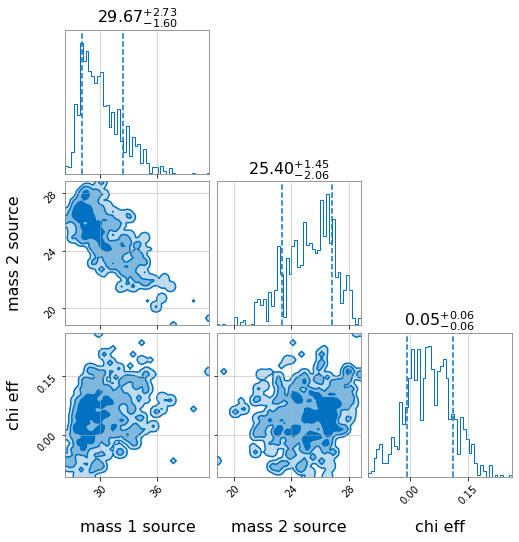

In [ ]:
result.plot_corner(parameters=["mass_1_source", "mass_2_source", "chi_eff"])

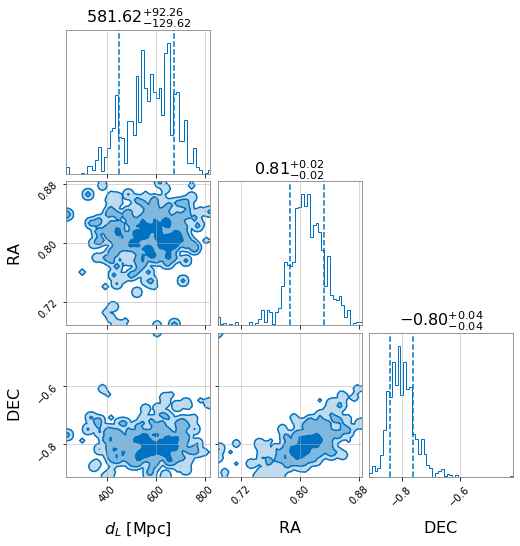

In [ ]:
result.plot_corner(parameters=["luminosity_distance", "ra", "dec"])

## Additional cells

Here's a small set of examples showing other things which are possible.

## Generating synthetic data

A standard use-case for `Bilby` is analysing signals injected into sythetic data.
The standard example for this is [here](https://git.ligo.org/lscsoft/bilby/blob/master/examples/gw_examples/injection_examples/fast_tutorial.py)

Creating the data and injecting the signal in this case is by doing the following.

```python
injection_parameters = dict(
    mass_1=36., mass_2=29., a_1=0.4, a_2=0.3, tilt_1=0.5, tilt_2=1.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=2000., theta_jn=0.4, psi=2.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1', 'K1'])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - 3)
ifos.inject_signal(waveform_generator=waveform_generator,
                   parameters=injection_parameters)
```

## Defining a new source model

Defining a new source model in `Bilby` just requires writing a python function.
There are a few conventions that must be followed.

```python
def time_domain_sine_gaussian(
        time_array, amplitude, phase, frequency, sigma
):
    """
    A time-domain sine-gaussian source model.

    This assumes the waveform is circularly polarised so we are free to set the
    cross term to be zero.

    This is based on https://lscsoft.docs.ligo.org/lalsuite/lalinference/group___l_a_l_inference_template__h.html#ga61ea5a03b8aeffaeb3155df1866cbdcf

    Parameters
    ----------
    time_array: array-like
        This is the array of times that the waveform will be evaluated at.
        This will be determined automatically by the WaveformGenerator that
        calls this function.
    amplitude: float
        Peak amplitude of the sine-gaussian burst.
    phase: float
        Phase of the burst at the time of peak amplitude.
    frequency: float
        Frequency of the sine wave.
    Sigma: float
        Width of the Gaussian in seconds.
    
    Returns
    -------
    dict: Dictionary containing array of plus polarisation.
    """
    if 20 * sigma >= time_array:
        raise ValueError("Sine-gaussian isn't contained in segment.")
    h_plus = np.zeros_like(time_array)
    
    idxs_after = time_array <= 10 * sigma
    time_after = time_array[idxs_after]
    scaled_time_after = time_after * sigma
    gaussian_term = np.exp(- scaled_time_after)
    sine_term = np.sin(2 * np.pi * frequency * time_after + phi)
    h_plus[times_after] = gaussian_term * sine_term

    idxs_before = time_array <= time_array[-1] - 10 * sigma
    time_before = time_array[idxs_before] - time_array[-1]
    scaled_time_before = time_before * sigma
    gaussian_term = np.exp(- scaled_time_before)
    sine_term = np.sin(2 * np.pi * frequency * time_before + phi)
    h_plus[times_after] = gaussian_term * sine_term

    return{'plus': h_plus}
```